# Import

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis
from scipy.stats import norm

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')


Mounted at /content/drive/


In [3]:
!pwd

/content/drive/My Drive


# 1. Data Load

**치매 예방을 위한 라이프로그 치매 분류**

**9,327 rows × 66 columns**

For more details https://aihub.or.kr/problem_contest/nipa-learning-platform/6

In [4]:
path = "./Colab Notebooks/DeepLearning/"

# original Tabular data : tab_data
tab_data =  pd.read_csv(path + "dementia_data.csv", parse_dates=['summary_date']) 
tab_data

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),DIAG_NM
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...,CN
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...,CN
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...,CN
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...,CN
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...,CN
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...,CN
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...,CN
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...,CN


# 2. EDA

**9,327 rows × 66 columns**

148명에 대한 데일리 라이프로그 데이터
크게 **1. 기본 정보 2. 걸음거리 3.수면 4.컨버팅 데이터**로 구분
**1. basic (3 cols)**
- timezone 시간 장소 정보
    - drop
    - 완벽한 null variable
- EMAIL
    - drop
    - 식별자 feature
- summary_date
    - pandas datetime type으로 사용

**2. activity (26 cols)**
- activity_class_5min, activity_met_1min, 하루간 5분당 활동 로그,하루간 1분당 MET 로그
    - drop
    - BLOB type -> js로 읽을 수 있다고는 함

**3. sleep (31 cols)**
- sleep_is_longest, 본 수면 여부
    - 전부 다 1
- sleep_temperature_trend_deviation, 피부 온도 경향 편차
    - 전부 다 99.99
- sleep_total, 수면 시간
    - 전부 다 \r
- sleep_temperature_deviation
    - drop
    - sleep_temperature_delta 랑 같은 변수
    - sleep_temperature_deviation 을 drop 하고 delta를 남길 것
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - 5분 당 심박동로그, 수면 상태 로그, 5분당 심박동변동 로그
    - drop
    - BLOB type

**4. converting**
- CONVERT(activity_class_5min USING utf8)
- CONVERT(activity_met_1min USING utf8)
- CONVERT(sleep_hr_5min USING utf8)
- CONVERT(sleep_hypnogram_5min USING utf8)
- CONVERT(sleep_rmssd_5min USING utf8)

**y variable**
- DIAG_NM
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)

In [5]:
tab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   EMAIL                                     9327 non-null   object        
 1   summary_date                              9327 non-null   datetime64[ns]
 2   activity_average_met                      9327 non-null   float64       
 3   activity_cal_active                       9327 non-null   int64         
 4   activity_cal_total                        9327 non-null   int64         
 5   activity_class_5min                       9327 non-null   object        
 6   activity_daily_movement                   9327 non-null   int64         
 7   activity_high                             9327 non-null   int64         
 8   activity_inactive                         9327 non-null   int64         
 9   activity_inactivity_alerts    

# 3. Preprocessing

**9,327 rows × 66 columns** ->
**9,327 rows × 49 columns**

**===================Default 하게 진행======================**

**feature drop**
- timezone
- EMAIL
- sleep_temperature_trend_deviation, sleep_is_longest, sleep_total
    - 모든 값이 1, '\r', 99.99 이므로 제거
- sleep_temperature_deviation
    - sleep_temperature_delta 변수와 중복되므로 deviation 변수를 제거
- activity_class_5min, activity_met_1min
    - convert data
- sleep_hr_5min, sleep_hypnogram_5min, sleep_rmssd_5min
    - convert data

- CONVERT(activity_class_5min USING utf8)
- CONVERT(activity_met_1min USING utf8)
- CONVERT(sleep_hr_5min USING utf8)
- CONVERT(sleep_hypnogram_5min USING utf8)
- CONVERT(sleep_rmssd_5min USING utf8)

**===================Sacaling & Transform 하게 진행===================**



**Scaling**
- Standard Scaler
- Robust Scale

**Transform**
- Log Transform
- Quantile Transform

**PCA**

**=========================Y Varible=========================**

- DIAG_NM
    - 정상(CN), 경도인지 장애(MCI), 치매(Dem)
    - Lable Encoding

So we may use 49 columns for training...

In [6]:
# data를 따로 관리합니다
# original data -> data
# preprocessing data -> processed_data
processed_data = tab_data.copy()

In [7]:
# Feature Selection - column drop
# drop 할 column을 아래와 같이 묶어서 정리합니다
# summary_date 추가
drop_cols = ['timezone', 'EMAIL',
             'activity_class_5min', 'activity_met_1min',
             'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min',
             'sleep_is_longest', 'sleep_temperature_trend_deviation', 'sleep_total', 'sleep_temperature_deviation',
             'summary_date']
convert_cols = tab_data.iloc[:, 60:65].columns

processed_data = processed_data.drop(drop_cols, axis=1)
processed_data = processed_data.drop(convert_cols, axis=1)
# 9327 x 49

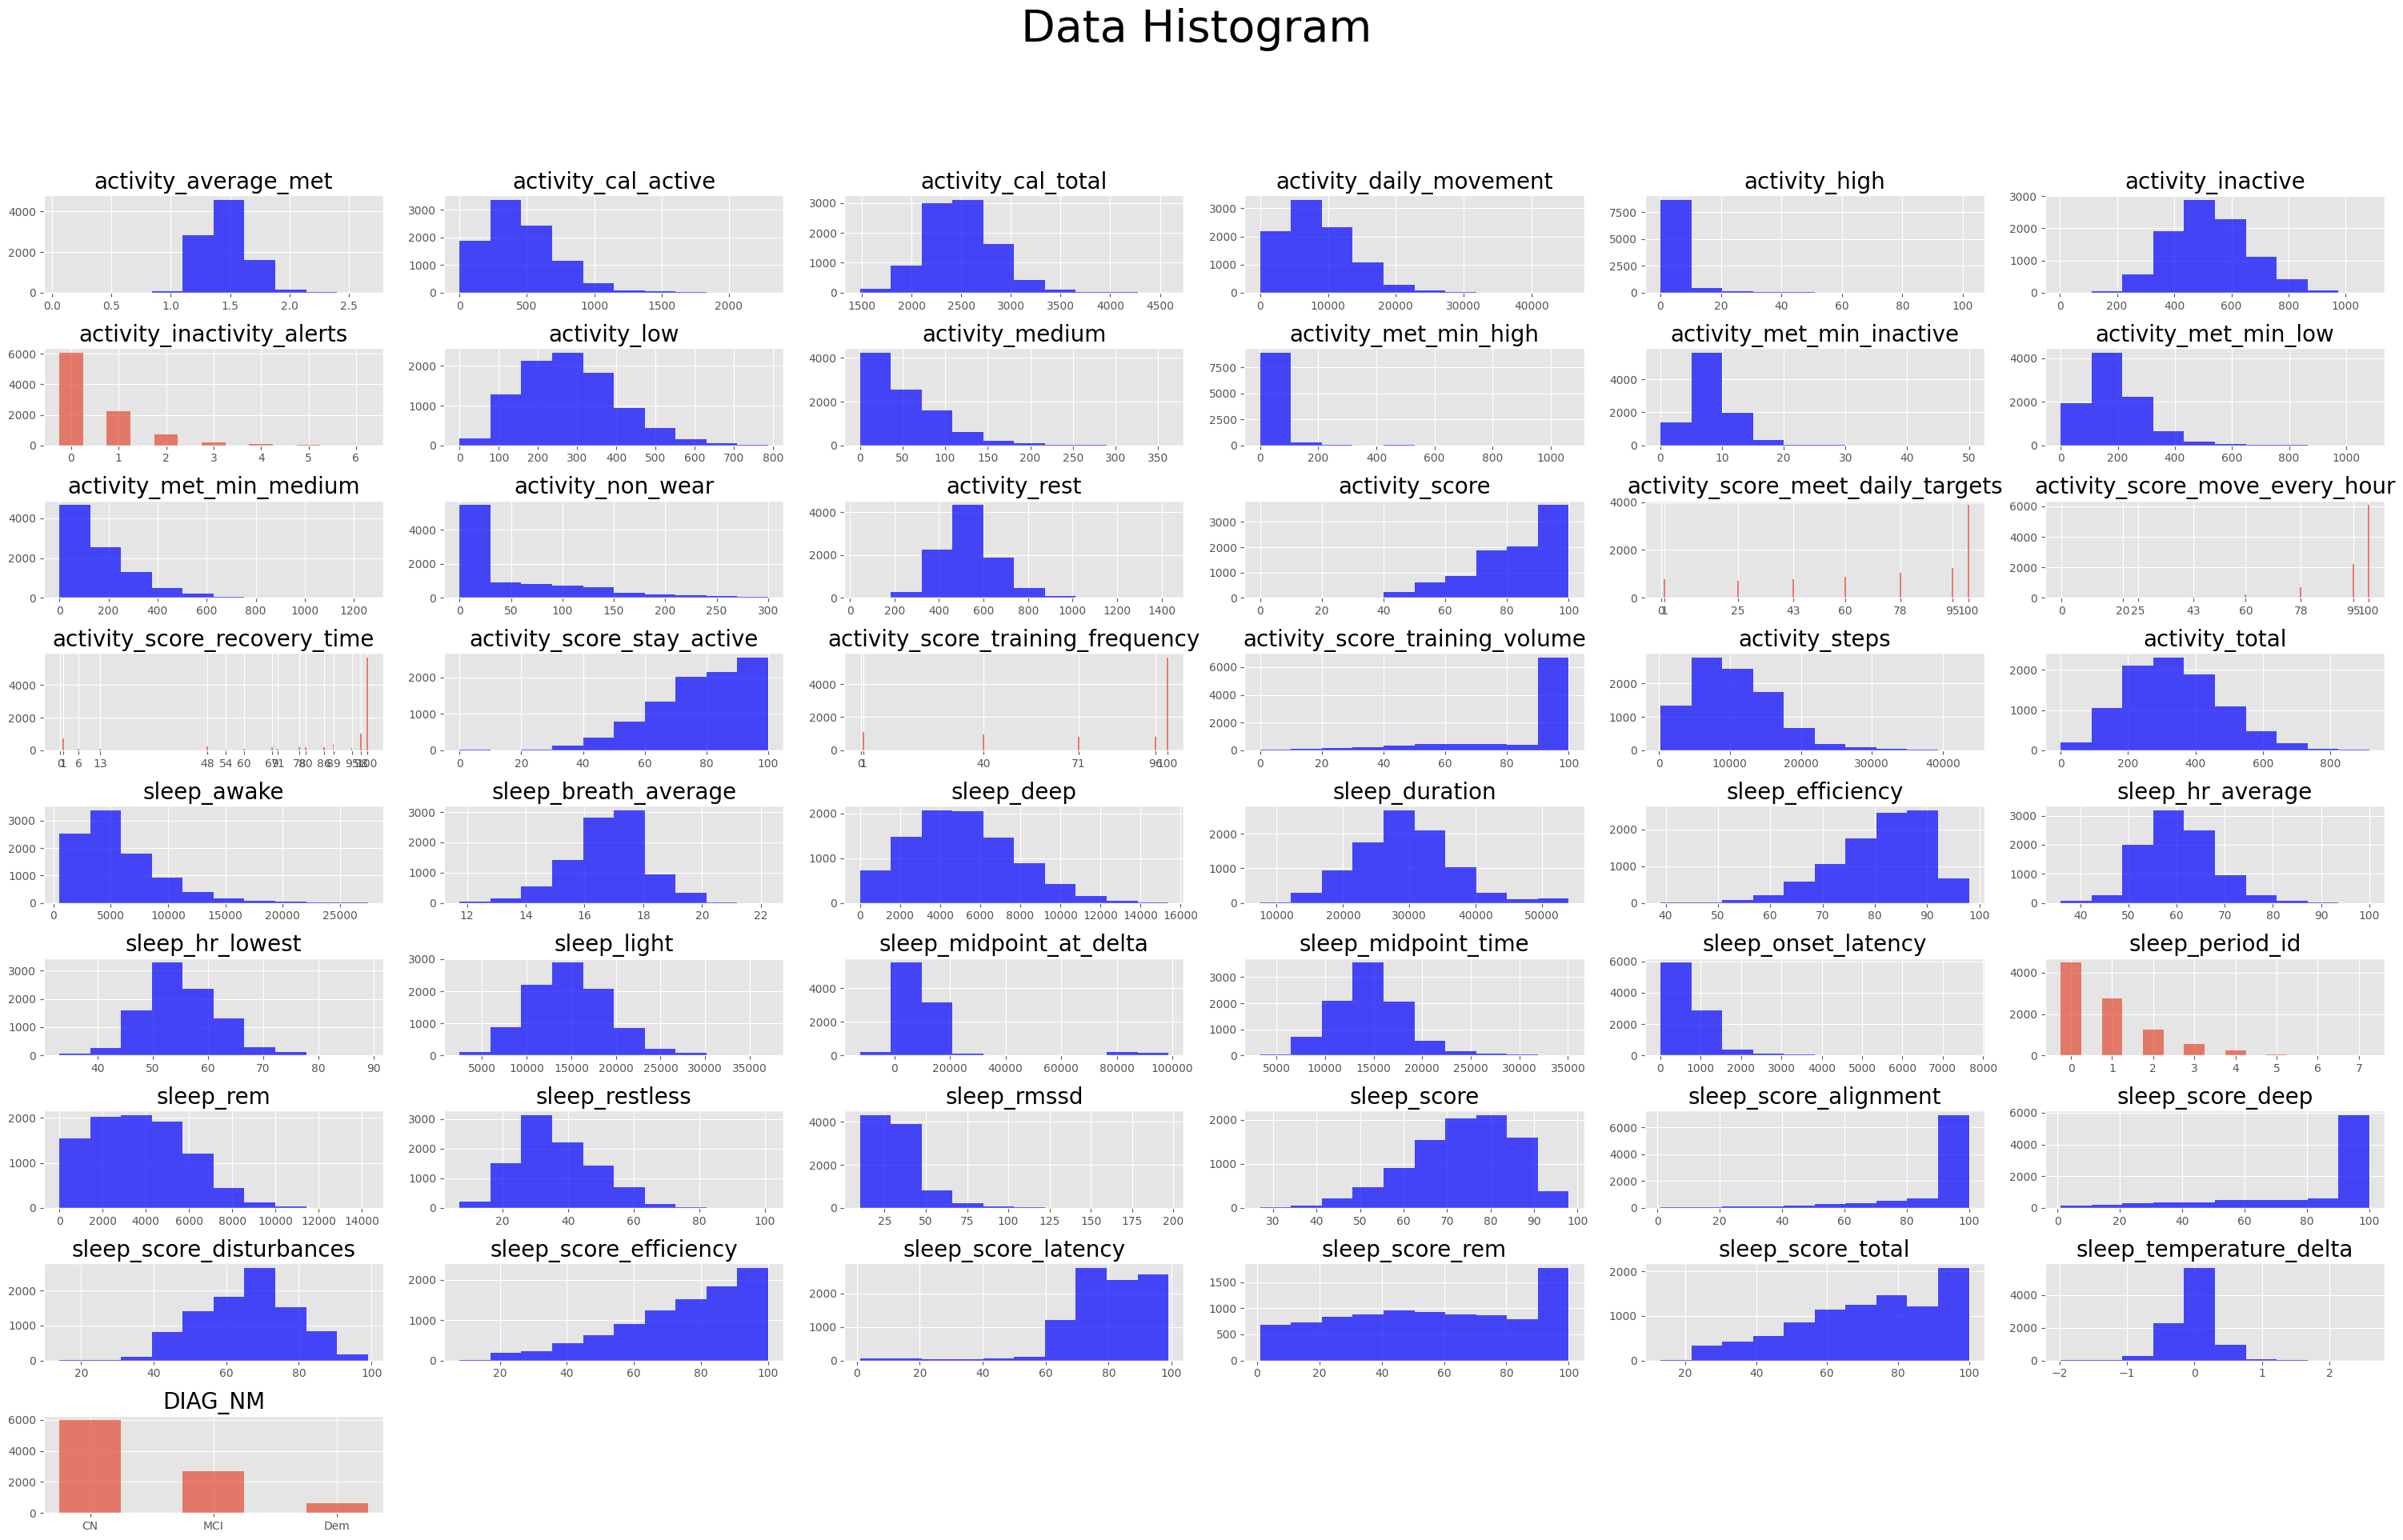

In [8]:
plt.style.use("ggplot")
plt.figure(figsize=(30, 40))
plt.suptitle("Data Histogram", fontsize=40)

cols = processed_data.columns
num_cols = len(cols)
rows = num_cols // 6 + (num_cols % 6 > 0)

for i in range(num_cols):
    plt.subplot(rows, 6, i+1)
    plt.title(cols[i], fontsize=20)
    if len(processed_data[cols[i]].unique()) > 20:
        plt.hist(processed_data[cols[i]], color='b', alpha=0.7)
    else:
        temp = processed_data[cols[i]].value_counts()
        plt.bar(temp.keys(), temp.values, width=0.5, alpha=0.7)
        plt.xticks(temp.keys())

plt.tight_layout(rect=[0, 0.5, 1, 0.95])
plt.show()


In [9]:
# Log Transform and Quantile Transform
# right skewed -> quantile transform -> 13개
# left skewed -> log transform -> 8개

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer, power_transform, QuantileTransformer

def quantileTransform(data) :
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['sleep_efficiency', 'sleep_score_alignment', 'sleep_score_deep', 'sleep_score_latency', 'sleep_score_total',
                    'activity_score', 'activity_score_stay_active', 'activity_score_training_volume']
right_skewed_cols = ['activity_cal_active', 'activity_daily_movement', 'activity_high', 'activity_medium', 'activity_met_min_high',
                     'activity_met_min_inactive', 'activity_met_min_low', 'activity_met_min_medium', 'activity_non_wear',
                     'activity_steps', 'sleep_awake', 'sleep_onset_latency', 'sleep_rmssd']

print(len(left_skewed_cols))
print(len(right_skewed_cols))

processed_data[left_skewed_cols] = logTransform(processed_data[left_skewed_cols])
processed_data[right_skewed_cols] = quantileTransform(processed_data[right_skewed_cols])
processed_data

8
13


,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,DIAG_NM
0,1.71875,0.853854,2944,0.866997,0.000000,417,0,545,0.543043,0.000000,...,62,4.615121,3.737670,50,27,4.584967,66,4.143135,-0.12,CN
1,1.40625,0.376877,2449,0.378487,0.000000,473,0,392,0.131131,0.000000,...,54,4.615121,3.912023,43,46,4.521789,35,3.806662,-0.32,CN
2,1.46875,0.477477,2544,0.455952,0.000000,586,0,362,0.330831,0.000000,...,61,4.615121,4.043051,47,34,4.499810,41,4.143135,0.07,CN
3,0.34375,0.002541,1850,0.005110,0.000000,176,0,34,0.030531,0.000000,...,55,4.615121,3.583519,40,44,4.465908,29,4.043051,-0.41,CN
4,1.46875,0.363363,2518,0.338338,0.000000,646,0,377,0.105606,0.000000,...,56,4.615121,4.174387,55,39,2.708050,54,4.094345,-0.27,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.34375,0.198198,2316,0.179805,0.748248,735,2,155,0.251752,0.741241,...,76,4.615121,3.988984,46,74,4.584967,84,4.418841,-0.16,CN
9323,1.34375,0.230731,2351,0.224214,0.547047,780,4,167,0.308809,0.530030,...,77,4.615121,3.555348,57,76,4.406719,95,4.465908,-0.09,CN
9324,1.53125,0.705706,2682,0.712793,0.547047,518,1,332,0.649650,0.530030,...,65,4.615121,0.693147,56,69,4.465908,89,4.174387,0.41,CN
9325,1.34375,0.303804,2331,0.280770,0.795295,578,0,173,0.397898,0.792292,...,81,4.615121,2.302585,59,86,4.499810,98,4.584967,0.27,CN


In [10]:
# Scaling
# processed -> processed1
standardScaler = RobustScaler()
scaled_data = processed_data.iloc[:, :48].copy()
scaled_data = pd.DataFrame(standardScaler.fit_transform(scaled_data), columns = scaled_data.columns)
processed_data.iloc[:, :48]=scaled_data

processed_data
processed_data1 = processed_data.copy()

<ipython-input-10-6cbf802fe2ef>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  processed_data.iloc[:, :48]=scaled_data


PCA를 이용한 변수

In [11]:
# PCA
from sklearn.decomposition import PCA

processed_data_y = processed_data['DIAG_NM']
processed_data_X = processed_data.drop('DIAG_NM', axis=1)

pca = PCA(n_components=4)
processed_data_X = pca.fit_transform(processed_data_X)
processed_data_X = pd.DataFrame(processed_data_X)

pca_data = pd.concat([processed_data_X, processed_data_y], axis=1)
pca_data

,0,1,2,3,DIAG_NM
0,-1.896928,0.280820,-2.113792,0.325131,CN
1,-1.012295,-0.840047,-1.837657,-0.070435,CN
2,-1.307828,-0.930679,-1.680573,0.186816,CN
3,0.237709,-2.657344,-1.580143,1.547869,CN
4,-0.751269,-1.560627,-1.132579,0.620042,CN
...,...,...,...,...,...
9322,-0.235337,-3.559231,1.550287,-0.395628,CN
9323,0.596563,-5.949309,5.576048,-1.980579,CN
9324,-0.850367,-1.348863,-0.582307,1.019629,CN
9325,-0.317716,-2.266151,-0.954263,2.028291,CN


# 4. Data Split

모든 전처리와 y variable labeling이 완료되었다.
train / valid / test data로 분할하고 용도에 맞게 model을 돌리도록 하자.

In [12]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# data를 따로 관리합니다
# preprocessing data -> processed_data
# input data -> input_data
input_data = processed_data.copy()

# y 변수와 X 변수 분할 관리
input_data_y = input_data['DIAG_NM'].copy()
input_data_X = input_data.drop(['DIAG_NM'], axis=1)

#PCA로 바로 압축한 변수가 아닌 Randomforest를 통해 중요도가 높은 변수들끼리 합친 변수에 사용
input_data_X1 = input_data_X.copy()

#변수를 새로 추가하지 않고 Encoder의 latent_vector 만 합친 데이터셋
input_data_X2 = input_data_X.copy()

#아무것도 추가하지 않은 데이터 셋
input_data_X3 = input_data_X.copy()

In [13]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
input_data_y = le.fit_transform(list(input_data_y))
print("original gain_label \n", le.classes_)
print("gain_lable label \n", set(input_data_y))

original gain_label 
 ['CN' 'Dem' 'MCI']
gain_lable label 
 {0, 1, 2}


Randomforest를 이용한 변수

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import pandas as pd

tr_X, test_X, tr_y, test_y = train_test_split(
    input_data_X,
    input_data_y,
    test_size = 0.2,
    random_state = 42,
    shuffle=True,
    stratify = input_data_y # Classification 중요 option
)

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier()
model.fit(tr_X, tr_y)

# 변수 중요도를 데이터 프레임으로 변환
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': tr_X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# # 변수를 4개의 그룹으로 나누기
num_groups = 4
group_size = len(tr_X.columns) // num_groups

grouped_features = []
grouped_data = []

for i in range(num_groups):
    start_index = i * group_size
    end_index = start_index + group_size if i < num_groups - 1 else len(tr_X.columns)
    group_features = feature_importances.iloc[start_index:end_index]['feature'].tolist()
    grouped_features += group_features

    # 데이터 선택
    selected_data_X = tr_X[group_features]

    # 그룹 데이터를 리스트에 추가
    grouped_data.append(selected_data_X)

    # 변수 이름 출력
    variables_str = ', '.join([f"'{var}'" for var in group_features])
    print(f"Group {i+1} Variables: {variables_str}")


Group 1 Variables: 'sleep_breath_average', 'sleep_hr_average', 'sleep_hr_lowest', 'sleep_midpoint_at_delta', 'sleep_rmssd', 'sleep_restless', 'sleep_light', 'activity_low', 'activity_rest', 'activity_cal_total', 'activity_score', 'activity_score_training_volume'
Group 2 Variables: 'sleep_score_disturbances', 'sleep_deep', 'activity_steps', 'activity_medium', 'activity_met_min_medium', 'activity_total', 'sleep_rem', 'activity_met_min_inactive', 'activity_met_min_low', 'activity_inactive', 'sleep_duration', 'activity_daily_movement'
Group 3 Variables: 'sleep_score_rem', 'sleep_midpoint_time', 'sleep_awake', 'activity_cal_active', 'sleep_score_total', 'sleep_score', 'activity_score_stay_active', 'sleep_temperature_delta', 'sleep_onset_latency', 'activity_score_meet_daily_targets', 'sleep_score_deep', 'sleep_score_efficiency'
Group 4 Variables: 'sleep_efficiency', 'activity_met_min_high', 'activity_non_wear', 'activity_average_met', 'sleep_score_latency', 'sleep_score_alignment', 'activity

In [15]:
group1 = ['sleep_breath_average', 'sleep_hr_average', 'sleep_midpoint_at_delta', 'sleep_hr_lowest', 'sleep_rmssd', 'sleep_restless', 'activity_cal_total', 'sleep_light', 'activity_rest', 'activity_total', 'sleep_score_disturbances', 'activity_steps']
group2 = ['activity_met_min_medium', 'activity_low', 'activity_score', 'activity_medium', 'sleep_rem', 'activity_score_training_volume', 'sleep_deep', 'activity_inactive', 'activity_met_min_low', 'sleep_duration', 'sleep_awake', 'activity_met_min_inactive']
group3 = ['activity_daily_movement', 'activity_cal_active', 'sleep_score_rem', 'sleep_midpoint_time', 'sleep_temperature_delta', 'activity_score_stay_active', 'sleep_score', 'activity_score_meet_daily_targets', 'sleep_score_total', 'sleep_efficiency', 'sleep_score_efficiency', 'sleep_onset_latency']
group4 = ['sleep_score_deep', 'activity_met_min_high', 'activity_non_wear', 'activity_average_met', 'sleep_score_latency', 'activity_high', 'sleep_score_alignment', 'activity_score_recovery_time', 'activity_score_training_frequency', 'sleep_period_id', 'activity_inactivity_alerts', 'activity_score_move_every_hour']

In [16]:
groups = [group1, group2, group3, group4]
pca_data1 = []

processed_data_y = processed_data1['DIAG_NM']
processed_data_X = processed_data1.drop('DIAG_NM', axis=1)

processed_data1

for group in groups:
    # 데이터 선택
    selected_data_X = processed_data_X[group]

    # PCA
    pca = PCA(n_components=1)
    selected_data_X_pca = pca.fit_transform(selected_data_X)

    # PCA 적용 후 데이터를 리스트에 추가
    pca_data1.append(selected_data_X_pca)

# 각 그룹의 PCA 결과 데이터를 수평으로 연결하여 하나의 변수로 합침
merged_data = np.hstack(pca_data1)

# Convert merged_data array into a DataFrame
merged_data_df = pd.DataFrame(merged_data)

# Result 확인
merged_data_df

,0,1,2,3
0,-0.858607,-1.370532,0.887600,-1.347238
1,-0.039595,-0.884008,2.089787,-1.280413
2,-0.798970,-0.813700,1.120859,-1.287558
3,0.305939,-0.348515,1.700177,-1.021949
4,-0.822821,0.225163,1.447453,-1.151857
...,...,...,...,...
9322,-0.067849,-0.125542,0.019290,-1.114199
9323,-0.251430,0.165866,-0.165366,-0.825568
9324,-0.111796,-0.713170,0.111987,-1.127096
9325,0.301633,-0.197368,-1.289579,-1.036178


# 5. 연속데이터 CNN으로 유미한 데이터로 뽑기
연속 데이터 이미지 파일로 바꾼 후 이용

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from IPython.display import Image

# in order to always get the same result
tf.random.set_seed(1)
np.random.seed(1)


In [18]:
# original image data : img_data
path = "./Colab Notebooks/DeepLearning/pic_dataset/"

FAST_RUN = False
IMAGE_WIDTH=34
IMAGE_HEIGHT=34
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

filenames = os.listdir(path)
categories = []

for filename in filenames:
    category = filename.split('_')[0]
    categories.append(category)

img_data = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

img_data

,filename,category
0,MCI_357.png,MCI
1,MCI_365.png,MCI
2,MCI_378.png,MCI
3,MCI_367.png,MCI
4,MCI_359.png,MCI
...,...,...
9322,CN_9011.png,CN
9323,CN_9052.png,CN
9324,CN_8988.png,CN
9325,CN_9001.png,CN


In [19]:
processed_img = []

for i in range(len(filenames)):
    mypath = path + '/' + filenames[i]
    print(mypath)
    data = cv.imread(mypath, 0)
    img = cv.resize(data, (28, 28))
    img = img / 255
    processed_img.append(img)

np_img = np.array(processed_img)
print(type(np_img))

input_img = np_img.reshape(len(processed_img), img.shape[0], img.shape[1], 1)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
./Colab Notebooks/DeepLearning/pic_dataset//CN_3776.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_4106.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3799.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3789.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3777.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_3943.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_3945.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3774.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3783.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_4110.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3780.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_3942.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_3948.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_4108.png
./Colab Notebooks/DeepLearning/pic_dataset//MCI_3938.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3775.png
./Colab Notebooks/DeepLearning/pic_dataset//CN_3767.png
./Co

Resnet + VAE

In [32]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda, BatchNormalization, Activation, Add
from keras.models import Model
import keras.backend as K

def resnet_block(inputs, filters, kernel_size=3, strides=1, activation='relu'):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, inputs])
    x = Activation(activation)(x)
    return x

def resnet_vae(input_shape, latent_dim):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=64)
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=128)
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Define Encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(volume_size[1] * volume_size[2] * volume_size[3])(decoder_input)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=128)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=64)
    x = Conv2DTranspose(filters=input_shape[2], kernel_size=3, padding='same')(x)
    outputs = Activation('sigmoid')(x)
    decoder = Model(decoder_input, outputs, name='decoder')

    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='resnet_vae')

    # VAE Loss function
    reconstruction_loss = K.mean(K.square(inputs - outputs), axis=[1, 2, 3])
    kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    # Compile the VAE model
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return encoder, decoder, vae

# 모델 생성
input_shape = (28, 28, 1)
latent_dim = 48
encoder, decoder,resnet_vae_model = resnet_vae(input_shape, latent_dim)

# 모델 요약 출력
resnet_vae_model.summary()

Model: "resnet_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 48),         1418592     ['input_7[0][0]']                
                                 (None, 48),                                                      
                                 (None, 48)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    1271169     ['encoder[0][2]']                
                                                                                         

VAE

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda, BatchNormalization, Activation
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae(input_shape, latent_dim):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Define Encoder model
    encoder_vae = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(7 * 7 * 128)(decoder_input)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=input_shape[2], kernel_size=3, strides=2, padding='same')(x)
    outputs = Activation('sigmoid')(x)
    decoder = Model(decoder_input, outputs, name='decoder')

    outputs = decoder(encoder_vae(inputs)[2])
    vae = Model(inputs, outputs, name='vae')

    # VAE Loss function
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - outputs), axis=[1, 2, 3])
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

    # Compile the VAE model
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')

    return encoder_vae, decoder, vae

# 모델 생성
input_shape = (28, 28, 1)
latent_dim = 16
encoder_vae, decoder, vae_model = vae(input_shape, latent_dim)

# 모델 요약 출력
vae_model.summary()


Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 16),         276000      ['input_13[0][0]']               
                                 (None, 16),                                                      
                                 (None, 16)]                                                      
                                                                                                  
 decoder (Functional)           (None, 28, 28, 1)    181249      ['encoder[0][2]']                
                                                                                                

VAE

In [21]:
vae_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse', metrics=['mse'])

vae_model.fit(input_img, input_img, ## 둘다 x_train 을 넣었다는 점이 point!!
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(input_img, input_img))

Epoch 1/5
292/292 [==============================] - 12s 13ms/step - loss: 0.1188 - mse: 0.0298 - val_loss: 0.0622 - val_mse: 0.0264
Epoch 2/5
292/292 [==============================] - 3s 9ms/step - loss: 0.0345 - mse: 0.0157 - val_loss: 0.0344 - val_mse: 0.0156
Epoch 3/5
292/292 [==============================] - 3s 11ms/step - loss: 0.0332 - mse: 0.0155 - val_loss: 0.0334 - val_mse: 0.0155
Epoch 4/5
292/292 [==============================] - 4s 14ms/step - loss: 0.0328 - mse: 0.0155 - val_loss: 0.0330 - val_mse: 0.0155
Epoch 5/5
292/292 [==============================] - 3s 9ms/step - loss: 0.0328 - mse: 0.0155 - val_loss: 0.0327 - val_mse: 0.0155


Resnet + VAE

In [52]:
resnet_vae_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mse', metrics=['mse'])

resnet_vae_model.fit(input_img, input_img, ## 둘다 x_train 을 넣었다는 점이 point!!
                epochs=5,
                batch_size=32,
                shuffle=True,
                validation_data=(input_img, input_img))

Epoch 1/5
292/292 [==============================] - 18s 51ms/step - loss: 0.2253 - mse: 0.0155 - val_loss: 0.0315 - val_mse: 0.0155
Epoch 2/5
292/292 [==============================] - 14s 48ms/step - loss: 0.0311 - mse: 0.0155 - val_loss: 0.0311 - val_mse: 0.0155
Epoch 3/5
292/292 [==============================] - 11s 39ms/step - loss: 0.0310 - mse: 0.0155 - val_loss: 0.0310 - val_mse: 0.0155
Epoch 4/5
292/292 [==============================] - 14s 48ms/step - loss: 0.0310 - mse: 0.0155 - val_loss: 0.0310 - val_mse: 0.0154
Epoch 5/5
292/292 [==============================] - 11s 39ms/step - loss: 0.0311 - mse: 0.0154 - val_loss: 0.0310 - val_mse: 0.0155


In [53]:
# Encoder 모델 정의
encoder_model = Model(inputs=encoder.input, outputs=encoder.get_layer('z').output)

# 입력 이미지에 대한 예측 수행
latent_vector5 = encoder_model.predict(input_img)

latent_vector5 = pd.DataFrame(latent_vector5)
latent_vector5

292/292 [==============================] - 1s 2ms/step


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,2.420062,0.593425,-1.258251,-0.755338,0.460974,-1.135615,1.197583,0.987068,1.149356,-0.072792,...,-0.091782,-1.899974,-0.637140,-0.062879,2.382074,0.084617,0.268551,0.047313,0.437801,0.329835
1,0.062606,-0.248964,0.844424,-0.928696,1.372670,1.417627,-1.177551,0.705879,0.343827,-0.160724,...,0.573676,-0.135544,-0.229791,-0.267939,0.053606,-1.648285,-0.681759,2.501097,0.217682,-1.935271
2,-0.760262,0.210036,-1.532010,-0.012771,0.201914,-0.485339,-1.186633,-0.065818,-1.221718,0.217206,...,1.499638,0.586341,1.437495,0.649193,-0.298165,0.363306,-1.915557,0.751094,0.188540,1.013753
3,-0.801937,0.714666,0.031367,-0.521573,-0.681178,0.477937,0.893539,-1.135189,1.085137,-0.376522,...,-0.846081,-0.669612,0.608253,-1.361171,-0.009810,0.515152,0.583443,-0.543573,0.122523,2.201815
4,1.359851,-1.335799,-0.639538,0.329179,-0.780027,-0.514405,-0.135519,-0.863258,-0.399095,-0.976644,...,-1.646779,0.760073,-1.314774,0.704325,0.549111,-0.499178,-1.266372,-1.028547,0.755384,-0.868580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,0.150549,0.515825,0.828495,1.266657,-1.445680,-0.687517,-0.053948,-0.822554,1.312990,0.135921,...,-1.888311,-1.365792,-0.226890,0.155813,-2.799335,0.200472,-1.336019,0.435121,-1.088166,-1.227551
9323,-0.798320,0.371953,-0.592359,1.977456,-0.021562,-1.155902,-1.231159,1.886235,0.917868,0.668763,...,1.429753,0.557584,-1.546723,0.149702,-0.116526,0.288365,1.432621,-0.218042,0.166359,-0.689026
9324,-0.521195,-0.132752,0.205879,-1.129398,0.828547,1.475901,0.514846,-0.073523,0.752145,0.028109,...,-0.552824,0.870398,-1.495127,-0.172474,-0.155497,-0.469997,0.162819,-0.621699,-1.257093,1.187562
9325,-0.667038,-0.229793,0.725055,0.644715,0.036541,-2.127384,0.579015,0.165775,2.285513,0.175338,...,-1.769059,0.066150,0.162425,1.153931,-0.820323,0.419171,0.059997,-0.411928,-1.074793,-0.835787


In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_data1 = pca.fit_transform(latent_vector5)
pca_data1 = pd.DataFrame(pca_data1)
pca_data1

,0
0,-1.727484
1,0.963088
2,1.666134
3,1.621478
4,-1.712075
...,...
9322,1.902159
9323,-0.980171
9324,-0.249973
9325,-2.051405


PCA + Latent

In [25]:
pca_data = pd.concat([pca_data, pca_data1], axis=1)
pca_data = pca_data.drop(['DIAG_NM'], axis=1)
pca_data

,0,1,2,3,0
0,-0.913480,-0.930877,-2.478338,1.561210,-1.727484
1,0.995512,-0.730126,-1.441353,-0.155199,0.963088
2,0.654839,-0.819732,-1.475013,-0.084798,1.666134
3,4.987305,1.198441,0.142355,-5.016961,1.621478
4,1.290475,-0.920937,-1.089832,-0.579167,-1.712075
...,...,...,...,...,...
9322,3.233839,-0.350784,3.236013,1.089134,1.902159
9323,4.958372,-1.004660,8.833288,4.915220,-0.980171
9324,0.642162,-0.537415,-0.707226,1.147296,-0.249973
9325,2.211539,0.657317,-0.885939,-1.512946,-2.051405


Importance + Latent

In [26]:
merged_data_df = pd.concat([merged_data_df, pca_data1], axis=1)
# merged_data_df = pca_data.drop(['DIAG_NM'], axis=1)
merged_data_df

,0,1,2,3,0
0,-0.888433,-1.439237,-0.627668,-0.911360,-1.727484
1,-0.037838,0.254968,-0.187630,-1.121559,0.963088
2,-0.800167,0.066936,0.233015,-1.096056,1.666134
3,0.328959,3.271118,3.112360,-1.868181,1.621478
4,-0.820583,1.044863,0.453002,-1.221138,-1.712075
...,...,...,...,...,...
9322,-0.030289,1.600922,1.445402,-1.811709,1.902159
9323,-0.222277,1.534764,1.569131,-3.023970,-0.980171
9324,-0.126537,-0.578655,-0.050744,-1.277025,-0.249973
9325,0.323792,1.044452,1.411500,-1.329390,-2.051405


input_data(ML data) + PCA + latent vector(Resnet + VAE vector) = input_data_X

In [27]:
# 9,327 x 48 -> 9,327 x 53
input_data_X = pd.concat([input_data_X, pca_data], axis=1)
input_data_X

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-0.913480,-0.930877,-2.478338,1.561210,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,0.995512,-0.730126,-1.441353,-0.155199,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-1.607143,0.342391,-0.283019,-0.395137,0.200000,0.654839,-0.819732,-1.475013,-0.084798,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,4.987305,1.198441,0.142355,-5.016961,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,1.290475,-0.920937,-1.089832,-0.579167,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,-0.178571,0.750000,0.528302,0.284701,-0.457143,3.233839,-0.350784,3.236013,1.089134,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,-0.107143,0.000000,0.735849,0.416413,-0.257143,4.958372,-1.004660,8.833288,4.915220,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.357143,0.222826,0.622642,-0.340426,1.171429,0.642162,-0.537415,-0.707226,1.147296,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.250000,0.342391,0.792453,0.787234,0.771429,2.211539,0.657317,-0.885939,-1.512946,-2.051405


input_data(ML data) + importancePCA +latent vector(Resnet + VAE vector) = input_data_X1

In [28]:
# 9,327 x 48 -> 9,327 x 53
input_data_X1 = pd.concat([input_data_X1, merged_data_df], axis=1)
input_data_X1

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-0.888433,-1.439237,-0.627668,-0.911360,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,-0.037838,0.254968,-0.187630,-1.121559,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-1.607143,0.342391,-0.283019,-0.395137,0.200000,-0.800167,0.066936,0.233015,-1.096056,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,0.328959,3.271118,3.112360,-1.868181,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,-0.820583,1.044863,0.453002,-1.221138,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,-0.178571,0.750000,0.528302,0.284701,-0.457143,-0.030289,1.600922,1.445402,-1.811709,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,-0.107143,0.000000,0.735849,0.416413,-0.257143,-0.222277,1.534764,1.569131,-3.023970,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.357143,0.222826,0.622642,-0.340426,1.171429,-0.126537,-0.578655,-0.050744,-1.277025,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.250000,0.342391,0.792453,0.787234,0.771429,0.323792,1.044452,1.411500,-1.329390,-2.051405


input_data(ML data) +latent vector(Resnet + VAE vector) = input_data_X2

In [29]:
# 9,327 x 48 -> 9,327 x 49
input_data_X2 = pd.concat([input_data_X2, pca_data1], axis=1)
input_data_X2

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,0.0625,0.0,-0.719547,-1.176471,-0.178571,0.750000,0.528302,0.284701,-0.457143,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,0.1250,0.0,-0.864967,-0.529412,-0.107143,0.000000,0.735849,0.416413,-0.257143,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.6250,0.0,-1.018886,-0.588235,-0.357143,0.222826,0.622642,-0.340426,1.171429,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.3750,0.0,-0.989613,-0.411765,0.250000,0.342391,0.792453,0.787234,0.771429,-2.051405


# 6. 모델 학습

In [30]:
input_data_X

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-0.913480,-0.930877,-2.478338,1.561210,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,0.995512,-0.730126,-1.441353,-0.155199,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-1.607143,0.342391,-0.283019,-0.395137,0.200000,0.654839,-0.819732,-1.475013,-0.084798,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,4.987305,1.198441,0.142355,-5.016961,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,1.290475,-0.920937,-1.089832,-0.579167,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,-0.178571,0.750000,0.528302,0.284701,-0.457143,3.233839,-0.350784,3.236013,1.089134,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,-0.107143,0.000000,0.735849,0.416413,-0.257143,4.958372,-1.004660,8.833288,4.915220,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.357143,0.222826,0.622642,-0.340426,1.171429,0.642162,-0.537415,-0.707226,1.147296,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.250000,0.342391,0.792453,0.787234,0.771429,2.211539,0.657317,-0.885939,-1.512946,-2.051405


In [31]:
input_data_X1

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0,1,2,3,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-0.888433,-1.439237,-0.627668,-0.911360,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,-0.037838,0.254968,-0.187630,-1.121559,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-1.607143,0.342391,-0.283019,-0.395137,0.200000,-0.800167,0.066936,0.233015,-1.096056,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,0.328959,3.271118,3.112360,-1.868181,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,-0.820583,1.044863,0.453002,-1.221138,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,-0.178571,0.750000,0.528302,0.284701,-0.457143,-0.030289,1.600922,1.445402,-1.811709,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,-0.107143,0.000000,0.735849,0.416413,-0.257143,-0.222277,1.534764,1.569131,-3.023970,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.357143,0.222826,0.622642,-0.340426,1.171429,-0.126537,-0.578655,-0.050744,-1.277025,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.250000,0.342391,0.792453,0.787234,0.771429,0.323792,1.044452,1.411500,-1.329390,-2.051405


In [32]:
input_data_X2

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score,sleep_score_alignment,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,0
0,1.285714,0.665495,1.086168,0.668473,-0.500000,-0.527174,0.0,1.658537,0.075683,-0.663194,...,-0.8125,0.0,-0.807365,-0.941176,-1.857143,0.750000,0.188679,-0.395137,-0.342857,-1.727484
1,-0.142857,-0.231609,-0.036281,-0.233596,-0.500000,-0.222826,0.0,0.725610,-1.076056,-0.663194,...,-1.3125,0.0,-0.754485,-1.352941,-1.178571,0.479167,-0.396226,-0.784195,-0.914286,0.963088
2,0.142857,-0.043432,0.179138,-0.080035,-0.500000,0.391304,0.0,0.542683,-0.373133,-0.663194,...,-0.8750,0.0,-0.684608,-1.117647,-1.607143,0.342391,-0.283019,-0.395137,0.200000,1.666134
3,-5.000000,-3.202093,-1.394558,-3.066443,-0.500000,-1.836957,0.0,-1.457317,-2.110900,-0.663194,...,-1.2500,0.0,-0.857413,-1.529412,-1.250000,0.222826,-0.509434,-0.552178,-1.171429,1.621478
4,0.142857,-0.263132,0.120181,-0.322668,-0.500000,0.717391,0.0,0.634146,-1.248967,-0.663194,...,-1.1875,0.0,-0.609065,-0.647059,-1.428571,-0.886651,-0.037736,-0.475177,-0.771429,-1.712075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,-0.428571,-0.715779,-0.337868,-0.784201,0.500000,1.201087,2.0,-0.719512,-0.599152,0.322629,...,0.0625,0.0,-0.719547,-1.176471,-0.178571,0.750000,0.528302,0.284701,-0.457143,1.902159
9323,-0.428571,-0.606569,-0.258503,-0.637338,0.000000,1.445652,4.0,-0.646341,-0.430502,0.000000,...,0.1250,0.0,-0.864967,-0.529412,-0.107143,0.000000,0.735849,0.416413,-0.257143,-0.980171
9324,0.428571,0.372629,0.492063,0.380131,0.000000,0.021739,1.0,0.359756,0.251772,0.000000,...,-0.6250,0.0,-1.018886,-0.588235,-0.357143,0.222826,0.622642,-0.340426,1.171429,-0.249973
9325,-0.428571,-0.406328,-0.303855,-0.469079,0.660964,0.347826,0.0,-0.609756,-0.225131,0.410734,...,0.3750,0.0,-0.989613,-0.411765,0.250000,0.342391,0.792453,0.787234,0.771429,-2.051405


In [33]:
input_data_y

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눔
train_X, val_X, train_y, val_y = train_test_split(
    input_data_X,
    input_data_y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=input_data_y
)

# 다시 검증 세트와 테스트 세트를 나눔
val_X, test_X, val_y, test_y = train_test_split(
    val_X,
    val_y,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=val_y
)


In [25]:
input_data_y
values = [0, 1, 2]

for value in values:
    if value in input_data_y:
        print(f"{value} is in the array.")
    else:
        print(f"{value} is not in the array.")

0 is in the array.
1 is in the array.
2 is in the array.


LSTM * 3 앙상블 모델 구현

In [38]:
from keras.layers import Concatenate, Attention
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization

# 첫 번째 LSTM 브랜치
input1 = Input(shape=(train_X.shape[1], 1))
lstm_branch1 = LSTM(50, return_sequences=True)(input1)
lstm_branch1 = BatchNormalization()(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)

# 두 번째 LSTM 브랜치
input2 = Input(shape=(train_X.shape[1], 1))
lstm_branch2 = LSTM(60, return_sequences=True)(input2)
lstm_branch2 = BatchNormalization()(lstm_branch2)
lstm_branch2 = Dropout(0.3)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(50, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.4)(lstm_branch2)
lstm_branch2 = LSTM(57, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(49)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)

# 세 번째 LSTM 브랜치
input3= Input(shape=(train_X.shape[1], 1))
lstm_branch3 = LSTM(55, return_sequences=True)(input3)
lstm_branch3 = BatchNormalization()(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(55, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(50)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)

# Attention 레이어
attention_layer = Attention()([lstm_branch1, lstm_branch2, lstm_branch3])

# 앙상블 모델
concatenated = Concatenate()([attention_layer, lstm_branch1, lstm_branch2, lstm_branch3])
dense1 = Dense(64)(concatenated)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32)(dropout1)
dropout2 = Dropout(0.2)(dense2)
output = Dense(3, activation='softmax')(dropout2)  # 클래스 수에 맞추어 출력 뉴런 수 조정, 활성화 함수를 'softmax'로 설정


ensemble_model = Model(inputs=[input1, input2, input3], outputs=output)
ensemble_model.summary()
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 48, 1)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 lstm_19 (LSTM)                 (None, 48, 50)       10400       ['input_9[0][0]']                
                                                                                                  
 lstm_25 (LSTM)                 (None, 48, 60)       14880       ['input_10[0][0]']               
                                                                                            

CNN + RNN 모델 구현

In [39]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

# 모델 구성
model = Sequential()

# CNN 레이어
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(53, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM 레이어
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))

# 완전 연결 레이어
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# 모델 요약 출력
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 51, 32)            128       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 dropout_42 (Dropout)        (None, 25, 32)            0         
                                                                 
 lstm_36 (LSTM)              (None, 25, 64)            24832     
                                                                 
 dropout_43 (Dropout)        (None, 25, 64)            0         
                                                                 
 lstm_37 (LSTM)              (None, 32)                12416     
                                                      

Resnet 구현

In [40]:
from keras.layers import Input, Dense, BatchNormalization, Activation, Reshape, GlobalAveragePooling1D
from keras.models import Model
from keras.optimizers import Adam

from keras.layers import GlobalAveragePooling2D

def residual_block(inputs, num_filters):
    x = Conv1D(num_filters, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if num_filters != inputs.shape[-1]:
        skip = Conv1D(num_filters, kernel_size=1, padding='same')(inputs)
    else:
        skip = inputs

    x = Add()([skip, x])
    x = Activation('relu')(x)
    return x

def create_resnet(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # Residual blocks
    x = residual_block(inputs, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Define the input shape and number of classes
input_shape = (train_X.shape[1], 1)
num_classes = 3

# Create the ResNet model
resnet_model = create_resnet(input_shape, num_classes)

# Compile the model
resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 48, 1)]      0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 48, 64)       256         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_55 (BatchN  (None, 48, 64)      256         ['conv1d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 48, 64)       0           ['batch_normalization_55[0]

# PCA 변수를 이용한 학습결과

In [39]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_2 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_3 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)


LSTM앙상블

In [44]:
# 학습 중 모델의 학습 결과를 저장할 파일명

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 앙상블 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
933/933 [==============================] - 49s 52ms/step - loss: 0.6391 - val_loss: 0.7372
Epoch 2/100
933/933 [==============================] - 48s 52ms/step - loss: 0.6234 - val_loss: 0.7019
Epoch 3/100
933/933 [==============================] - 48s 51ms/step - loss: 0.6149 - val_loss: 0.6761
Epoch 4/100
933/933 [==============================] - 51s 54ms/step - loss: 0.5999 - val_loss: 0.6810
Epoch 5/100
933/933 [==============================] - 47s 51ms/step - loss: 0.5946 - val_loss: 0.6737
Epoch 6/100
933/933 [==============================] - 48s 52ms/step - loss: 0.5768 - val_loss: 0.6960
Epoch 7/100
933/933 [==============================] - 47s 50ms/step - loss: 0.5648 - val_loss: 0.6827
Epoch 8/100
933/933 [==============================] - 48s 52ms/step - loss: 0.5575 - val_loss: 0.6673
Epoch 9/100
933/933 [==============================] - 47s 50ms/step - loss: 0.5504 - val_loss: 0.6981
Epoch 10/100
933/933 [==============================] - 47s 51ms/step - l

In [42]:
ensemble_model.save('drive/MyDrive/LSTMensa_model.h5')
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))


30/30 [==============================] - 6s 20ms/step
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       597
           1       0.65      0.34      0.44        65
           2       0.63      0.39      0.48       271

    accuracy                           0.71       933
   macro avg       0.67      0.54      0.57       933
weighted avg       0.69      0.71      0.68       933



CNN+LSTM

In [45]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.8044 - val_loss: 0.7861
Epoch 2/100
3731/3731 [==============================] - 30s 8ms/step - loss: 0.7955 - val_loss: 0.7817
Epoch 3/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7901 - val_loss: 0.7849
Epoch 4/100
3731/3731 [==============================] - 32s 8ms/step - loss: 0.7801 - val_loss: 0.7725
Epoch 5/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7780 - val_loss: 0.7744
Epoch 6/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7710 - val_loss: 0.7708
Epoch 7/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7652 - val_loss: 0.7588
Epoch 8/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7560 - val_loss: 0.7609
Epoch 9/100
3731/3731 [==============================] - 31s 8ms/step - loss: 0.7460 - val_loss: 0.7431
Epoch 10/100
3731/3731 [==============================] - 30s 8m

In [46]:
model.save('drive/MyDrive/CNN_LSTM_model.h5')
pred_rf = model.predict(test_X)
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       597
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       271

    accuracy                           0.64       933
   macro avg       0.21      0.33      0.26       933
weighted avg       0.41      0.64      0.50       933



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resnet

In [47]:
import numpy as np

train_X = train_X.to_numpy()  # DataFrame을 NumPy 배열로 변환
val_X = val_X.to_numpy()

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = resnet_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 11s 17ms/step - loss: 0.8289 - accuracy: 0.6202 - val_loss: 0.9546 - val_accuracy: 0.6399
Epoch 2/100
467/467 [==============================] - 6s 13ms/step - loss: 0.7727 - accuracy: 0.6411 - val_loss: 0.8713 - val_accuracy: 0.6259
Epoch 3/100
467/467 [==============================] - 5s 12ms/step - loss: 0.7375 - accuracy: 0.6567 - val_loss: 1.1182 - val_accuracy: 0.6056
Epoch 4/100
467/467 [==============================] - 5s 11ms/step - loss: 0.7020 - accuracy: 0.6755 - val_loss: 0.6947 - val_accuracy: 0.6613
Epoch 5/100
467/467 [==============================] - 8s 16ms/step - loss: 0.6814 - accuracy: 0.6828 - val_loss: 0.7882 - val_accuracy: 0.6313
Epoch 6/100
467/467 [==============================] - 5s 11ms/step - loss: 0.6431 - accuracy: 0.7031 - val_loss: 1.3378 - val_accuracy: 0.6506
Epoch 7/100
467/467 [==============================] - 7s 15ms/step - loss: 0.6050 - accuracy: 0.7224 - val_loss: 1.0725 - val_accuracy

In [48]:
resnet_model.save('drive/MyDrive/Resnet_model.h5')
test_X_expanded = np.expand_dims(test_X, axis=2)  
pred_rf = resnet_model.predict(test_X_expanded)
pred_rf_classes = np.argmax(pred_rf, axis=1)
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.74      0.84      0.78       597
           1       0.52      0.42      0.46        65
           2       0.60      0.45      0.51       271

    accuracy                           0.69       933
   macro avg       0.62      0.57      0.58       933
weighted avg       0.68      0.69      0.68       933



# Importacne 변수를 이용한 학습 결과

In [49]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눔
train_X, val_X, train_y, val_y = train_test_split(
    input_data_X1,
    input_data_y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=input_data_y
)

# 다시 검증 세트와 테스트 세트를 나눔
val_X, test_X, val_y, test_y = train_test_split(
    val_X,
    val_y,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=val_y
)


In [50]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_2 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_3 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)


LSTM 앙상블

In [51]:
# 학습 중 모델의 학습 결과를 저장할 파일명

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 앙상블 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 23s 50ms/step - loss: 0.5176 - val_loss: 0.6699
Epoch 2/100
467/467 [==============================] - 23s 50ms/step - loss: 0.5165 - val_loss: 0.6760
Epoch 3/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4919 - val_loss: 0.7275
Epoch 4/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4908 - val_loss: 0.7360
Epoch 5/100
467/467 [==============================] - 24s 52ms/step - loss: 0.4865 - val_loss: 0.7188
Epoch 6/100
467/467 [==============================] - 27s 57ms/step - loss: 0.4793 - val_loss: 0.6534
Epoch 7/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4697 - val_loss: 0.6661
Epoch 8/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4638 - val_loss: 0.6997
Epoch 9/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4518 - val_loss: 0.8311
Epoch 10/100
467/467 [==============================] - 23s 48ms/step - l

In [52]:
ensemble_model.save('drive/MyDrive/LSTMensa_import_model.h5')
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       597
           1       0.58      0.51      0.54        65
           2       0.67      0.53      0.59       271

    accuracy                           0.74       933
   macro avg       0.67      0.63      0.65       933
weighted avg       0.73      0.74      0.73       933



CNN + LSTM

In [53]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=4,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)



Epoch 1/100
1866/1866 [==============================] - 22s 12ms/step - loss: 0.4844 - val_loss: 0.6671
Epoch 2/100
1866/1866 [==============================] - 16s 8ms/step - loss: 0.4565 - val_loss: 0.6393
Epoch 3/100
1866/1866 [==============================] - 15s 8ms/step - loss: 0.4398 - val_loss: 0.6667
Epoch 4/100
1866/1866 [==============================] - 15s 8ms/step - loss: 0.4233 - val_loss: 0.6945
Epoch 5/100
1866/1866 [==============================] - 15s 8ms/step - loss: 0.4280 - val_loss: 0.6788
Epoch 6/100
1866/1866 [==============================] - 16s 8ms/step - loss: 0.4097 - val_loss: 0.6627
Epoch 7/100
1866/1866 [==============================] - 15s 8ms/step - loss: 0.4036 - val_loss: 0.6775


In [54]:
model.save('drive/MyDrive/CNN_LSTM_import_model.h5')
pred_rf = model.predict(test_X)
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       597
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       271

    accuracy                           0.64       933
   macro avg       0.21      0.33      0.26       933
weighted avg       0.41      0.64      0.50       933



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resnet

In [55]:
import numpy as np

train_X = train_X.to_numpy()  
val_X = val_X.to_numpy()

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = resnet_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 6s 14ms/step - loss: 0.6844 - accuracy: 0.6829 - val_loss: 0.9375 - val_accuracy: 0.5305
Epoch 2/100
467/467 [==============================] - 5s 11ms/step - loss: 0.6468 - accuracy: 0.7027 - val_loss: 0.6665 - val_accuracy: 0.7042
Epoch 3/100
467/467 [==============================] - 6s 13ms/step - loss: 0.6016 - accuracy: 0.7197 - val_loss: 0.9705 - val_accuracy: 0.6988
Epoch 4/100
467/467 [==============================] - 5s 11ms/step - loss: 0.5720 - accuracy: 0.7413 - val_loss: 0.7619 - val_accuracy: 0.6238
Epoch 5/100
467/467 [==============================] - 5s 11ms/step - loss: 0.5552 - accuracy: 0.7526 - val_loss: 0.7943 - val_accuracy: 0.7042
Epoch 6/100
467/467 [==============================] - 6s 13ms/step - loss: 0.5204 - accuracy: 0.7658 - val_loss: 0.7475 - val_accuracy: 0.7278
Epoch 7/100
467/467 [==============================] - 5s 11ms/step - loss: 0.4849 - accuracy: 0.7865 - val_loss: 0.9336 - val_accuracy:

In [56]:
resnet_model.save('drive/MyDrive/Resnet_import_model.h5')
test_X_expanded = np.expand_dims(test_X, axis=2)  
pred_rf = resnet_model.predict(test_X_expanded)
pred_rf_classes = np.argmax(pred_rf, axis=1)
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       597
           1       0.67      0.51      0.58        65
           2       0.67      0.28      0.39       271

    accuracy                           0.70       933
   macro avg       0.68      0.57      0.59       933
weighted avg       0.69      0.70      0.67       933



# latent_vector만을 이용한 학습 결과

In [57]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눔
train_X, val_X, train_y, val_y = train_test_split(
    input_data_X2,
    input_data_y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=input_data_y
)

# 다시 검증 세트와 테스트 세트를 나눔
val_X, test_X, val_y, test_y = train_test_split(
    val_X,
    val_y,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=val_y
)


In [58]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_2 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_3 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)


LSTM 앙상블

In [59]:
# 학습 중 모델의 학습 결과를 저장할 파일명

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 앙상블 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 77s 61ms/step - loss: 0.5055 - val_loss: 0.7028
Epoch 2/100
467/467 [==============================] - 23s 50ms/step - loss: 0.4824 - val_loss: 0.7225
Epoch 3/100
467/467 [==============================] - 24s 50ms/step - loss: 0.4697 - val_loss: 0.6939
Epoch 4/100
467/467 [==============================] - 23s 49ms/step - loss: 0.4624 - val_loss: 0.6830
Epoch 5/100
467/467 [==============================] - 23s 50ms/step - loss: 0.4481 - val_loss: 0.7249
Epoch 6/100
467/467 [==============================] - 23s 49ms/step - loss: 0.4471 - val_loss: 0.6864
Epoch 7/100
467/467 [==============================] - 22s 48ms/step - loss: 0.4466 - val_loss: 0.7218
Epoch 8/100
467/467 [==============================] - 33s 71ms/step - loss: 0.4198 - val_loss: 0.6954
Epoch 9/100
467/467 [==============================] - 34s 72ms/step - loss: 0.4252 - val_loss: 0.7485


In [60]:
ensemble_model.save('drive/MyDrive/LSTMensa_latent_model.h5')
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))


30/30 [==============================] - 7s 19ms/step
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       597
           1       0.70      0.46      0.56        65
           2       0.58      0.61      0.59       271

    accuracy                           0.72       933
   macro avg       0.69      0.62      0.65       933
weighted avg       0.72      0.72      0.72       933



CNN + LSTM

In [61]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)

Epoch 1/100
467/467 [==============================] - 6s 9ms/step - loss: 0.5726 - val_loss: 0.6881
Epoch 2/100
467/467 [==============================] - 5s 12ms/step - loss: 0.4990 - val_loss: 0.6696
Epoch 3/100
467/467 [==============================] - 5s 12ms/step - loss: 0.4701 - val_loss: 0.6772
Epoch 4/100
467/467 [==============================] - 5s 11ms/step - loss: 0.4495 - val_loss: 0.6550
Epoch 5/100
467/467 [==============================] - 4s 9ms/step - loss: 0.4358 - val_loss: 0.6955
Epoch 6/100
467/467 [==============================] - 3s 7ms/step - loss: 0.4243 - val_loss: 0.6512
Epoch 7/100
467/467 [==============================] - 4s 8ms/step - loss: 0.4115 - val_loss: 0.6505
Epoch 8/100
467/467 [==============================] - 5s 10ms/step - loss: 0.4123 - val_loss: 0.6498
Epoch 9/100
467/467 [==============================] - 4s 8ms/step - loss: 0.4042 - val_loss: 0.6386
Epoch 10/100
467/467 [==============================] - 4s 8ms/step - loss: 0.3927 - va

In [62]:
model.save('drive/MyDrive/CNN_LSTM_latent_model.h5')
pred_rf = model.predict(test_X)
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       597
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       271

    accuracy                           0.64       933
   macro avg       0.21      0.33      0.26       933
weighted avg       0.41      0.64      0.50       933



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resnet

In [63]:
import numpy as np

train_X = train_X.to_numpy()  
val_X = val_X.to_numpy()

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = resnet_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 9s 14ms/step - loss: 0.5944 - accuracy: 0.7301 - val_loss: 0.7207 - val_accuracy: 0.6570
Epoch 2/100
467/467 [==============================] - 5s 11ms/step - loss: 0.5637 - accuracy: 0.7456 - val_loss: 0.6806 - val_accuracy: 0.6999
Epoch 3/100
467/467 [==============================] - 6s 14ms/step - loss: 0.5427 - accuracy: 0.7570 - val_loss: 0.7820 - val_accuracy: 0.7031
Epoch 4/100
467/467 [==============================] - 5s 11ms/step - loss: 0.5103 - accuracy: 0.7795 - val_loss: 0.7047 - val_accuracy: 0.6645
Epoch 5/100
467/467 [==============================] - 7s 14ms/step - loss: 0.4925 - accuracy: 0.7810 - val_loss: 0.6805 - val_accuracy: 0.7149
Epoch 6/100
467/467 [==============================] - 5s 11ms/step - loss: 0.4568 - accuracy: 0.8039 - val_loss: 0.9595 - val_accuracy: 0.7042
Epoch 7/100
467/467 [==============================] - 6s 12ms/step - loss: 0.4280 - accuracy: 0.8125 - val_loss: 0.6611 - val_accuracy:

In [64]:
resnet_model.save('drive/MyDrive/Resnet_latent_model.h5')
test_X_expanded = np.expand_dims(test_X, axis=2)  
pred_rf = resnet_model.predict(test_X_expanded)
pred_rf_classes = np.argmax(pred_rf, axis=1)
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       597
           1       0.84      0.40      0.54        65
           2       0.58      0.69      0.63       271

    accuracy                           0.73       933
   macro avg       0.74      0.63      0.66       933
weighted avg       0.75      0.73      0.73       933



# 제공 변수만을 이용한 학습 결과

In [65]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.utils import check_array
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나눔
train_X, val_X, train_y, val_y = train_test_split(
    input_data_X3,
    input_data_y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=input_data_y
)

# 다시 검증 세트와 테스트 세트를 나눔
val_X, test_X, val_y, test_y = train_test_split(
    val_X,
    val_y,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=val_y
)


In [66]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_2 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)
test_X_3 = test_X.values.reshape(test_X.shape[0], test_X.shape[1], 1)

LSTM 앙상블

In [67]:
# 학습 중 모델의 학습 결과를 저장할 파일명

from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 앙상블 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 24s 51ms/step - loss: 0.4494 - val_loss: 0.7457
Epoch 2/100
467/467 [==============================] - 23s 48ms/step - loss: 0.4371 - val_loss: 0.7434
Epoch 3/100
467/467 [==============================] - 23s 50ms/step - loss: 0.4339 - val_loss: 0.7154
Epoch 4/100
467/467 [==============================] - 22s 48ms/step - loss: 0.4434 - val_loss: 0.6758
Epoch 5/100
467/467 [==============================] - 23s 49ms/step - loss: 0.4237 - val_loss: 0.6813
Epoch 6/100
467/467 [==============================] - 23s 50ms/step - loss: 0.4198 - val_loss: 0.6997
Epoch 7/100
467/467 [==============================] - 22s 47ms/step - loss: 0.4043 - val_loss: 0.7629
Epoch 8/100
467/467 [==============================] - 23s 49ms/step - loss: 0.3950 - val_loss: 0.7455
Epoch 9/100
467/467 [==============================] - 23s 49ms/step - loss: 0.3997 - val_loss: 0.8027


In [68]:
ensemble_model.save('drive/MyDrive/LSTMensa_org_model.h5')
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       597
           1       0.74      0.48      0.58        65
           2       0.58      0.60      0.59       271

    accuracy                           0.72       933
   macro avg       0.70      0.63      0.65       933
weighted avg       0.72      0.72      0.72       933



CNN + LSTM

In [69]:
# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)

Epoch 1/100
467/467 [==============================] - 5s 10ms/step - loss: 0.3905 - val_loss: 0.6736
Epoch 2/100
467/467 [==============================] - 4s 8ms/step - loss: 0.3862 - val_loss: 0.6567
Epoch 3/100
467/467 [==============================] - 4s 8ms/step - loss: 0.3737 - val_loss: 0.6476
Epoch 4/100
467/467 [==============================] - 4s 9ms/step - loss: 0.3676 - val_loss: 0.6534
Epoch 5/100
467/467 [==============================] - 4s 9ms/step - loss: 0.3601 - val_loss: 0.6866
Epoch 6/100
467/467 [==============================] - 4s 8ms/step - loss: 0.3694 - val_loss: 0.6577
Epoch 7/100
467/467 [==============================] - 3s 7ms/step - loss: 0.3602 - val_loss: 0.6501
Epoch 8/100
467/467 [==============================] - 5s 10ms/step - loss: 0.3562 - val_loss: 0.6578


In [70]:
model.save('drive/MyDrive/CNN_LSTM_org_model.h5')
pred_rf = model.predict(test_X)
pred_rf_classes = np.argmax(pred_rf, axis=1)  
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       597
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00       271

    accuracy                           0.64       933
   macro avg       0.21      0.33      0.26       933
weighted avg       0.41      0.64      0.50       933



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Resnet

In [71]:
import numpy as np

train_X = train_X.to_numpy()  
val_X = val_X.to_numpy()

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
val_X = val_X.reshape(val_X.shape[0], val_X.shape[1], 1)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)


history = resnet_model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


Epoch 1/100
467/467 [==============================] - 7s 14ms/step - loss: 0.3933 - accuracy: 0.8283 - val_loss: 1.4033 - val_accuracy: 0.4973
Epoch 2/100
467/467 [==============================] - 5s 12ms/step - loss: 0.3619 - accuracy: 0.8459 - val_loss: 0.6918 - val_accuracy: 0.7299
Epoch 3/100
467/467 [==============================] - 7s 14ms/step - loss: 0.3397 - accuracy: 0.8570 - val_loss: 0.6046 - val_accuracy: 0.7642
Epoch 4/100
467/467 [==============================] - 5s 11ms/step - loss: 0.3227 - accuracy: 0.8666 - val_loss: 0.8578 - val_accuracy: 0.6527
Epoch 5/100
467/467 [==============================] - 6s 13ms/step - loss: 0.3050 - accuracy: 0.8744 - val_loss: 0.6959 - val_accuracy: 0.7492
Epoch 6/100
467/467 [==============================] - 5s 12ms/step - loss: 0.2657 - accuracy: 0.8890 - val_loss: 1.0492 - val_accuracy: 0.7160
Epoch 7/100
467/467 [==============================] - 5s 11ms/step - loss: 0.2621 - accuracy: 0.8937 - val_loss: 0.9205 - val_accuracy:

In [72]:
resnet_model.save('drive/MyDrive/Resnet_org_model.h5')
test_X_expanded = np.expand_dims(test_X, axis=2)  
pred_rf = resnet_model.predict(test_X_expanded)
pred_rf_classes = np.argmax(pred_rf, axis=1)
print(classification_report(test_y, pred_rf_classes))

30/30 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       597
           1       0.63      0.80      0.70        65
           2       0.67      0.67      0.67       271

    accuracy                           0.78       933
   macro avg       0.72      0.77      0.74       933
weighted avg       0.78      0.78      0.78       933

